In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime

import custom_dataset as ds
from model import samplenet, samplenet2d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
def inference_model(model, dataset, batch_size=16):
    with torch.no_grad():
        model.eval()
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        ret = []
        for X in tqdm(dataloader):
            X = X.to(model.device)
            for i in range(dataset.next_step-1):
                y_pred = model(X)
                X = torch.cat([X[:, 1:], y_pred], dim=1)                
            y_pred = model(X)
            ret.append(y_pred.cpu().squeeze())
    return ret

# Load model

In [3]:
path = './model/samplenet_1.pt'
prev_len = 3
md = samplenet.SampleNet(device, prev_len)
md.load_state_dict(torch.load(path))

<All keys matched successfully>

# Inference

In [4]:
next_step = 12

train_data_path = './data/processed_data/traffic/202310.csv'
node_path = './data/processed_data/node_link/daegu_selected_nodes.csv'
link_path = './data/processed_data/node_link/daegu_selected_links.csv'

inf_data = ds.Link1d_Dataset(train_data_path, prev_len, next_step, get_true=False)
ret = inference_model(md, inf_data)

100%|███████████████████████████████████████████████████████████████████████████████| 539/539 [00:04<00:00, 125.47it/s]


In [5]:
print(ret)

[tensor([[28.1782, 31.7916, 26.8320,  ..., 23.0626, 20.8512, 18.2992],
        [30.9271, 35.8282, 28.0606,  ..., 23.0626, 20.8512, 18.2992],
        [27.5791, 35.5681, 28.0076,  ..., 23.0626, 20.8512, 18.2992],
        ...,
        [25.4686, 30.6010, 23.7722,  ..., 23.0626, 20.8512, 18.2992],
        [23.9943, 30.4536, 25.0990,  ..., 23.0626, 20.8512, 18.2992],
        [29.6263, 34.0435, 22.7348,  ..., 23.0626, 20.8512, 18.2992]]), tensor([[32.8494, 36.3639, 21.1429,  ..., 23.0626, 20.8512, 18.2992],
        [34.4017, 34.6934, 21.4947,  ..., 23.0626, 20.8512, 18.2992],
        [35.7751, 33.8554, 21.3102,  ..., 23.0626, 20.8512, 18.2992],
        ...,
        [22.8135, 36.8749, 45.9143,  ..., 23.0626, 20.8512, 18.2992],
        [19.7226, 37.0685, 45.9143,  ..., 23.0626, 20.8512, 18.2992],
        [18.8541, 37.6068, 32.7092,  ..., 23.0626, 20.8512, 18.2992]]), tensor([[25.3453, 38.7245, 23.8976,  ..., 23.0626, 20.8512, 18.2992],
        [19.6013, 36.7888, 27.3801,  ..., 23.0626, 20.8512,

# Save inference data

In [10]:
result = pd.DataFrame(torch.cat(ret).numpy())
result.columns = pd.read_csv('./data/processed_data/node_link/daegu_selected_links.csv')['LINK_ID'].values

In [7]:
result.to_csv(f'./data/inference_result/202310_{next_step}.csv', index=False)

# Plot result

In [11]:
def show_plot(time, d1, d2):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(time, d1, 'r')
    ax.plot(time, d2, 'b')
    ax.grid(True)
    ax.set_xlabel('Time', loc='right')
    ax.set_ylabel('Speed', loc='top')
    plt.show()

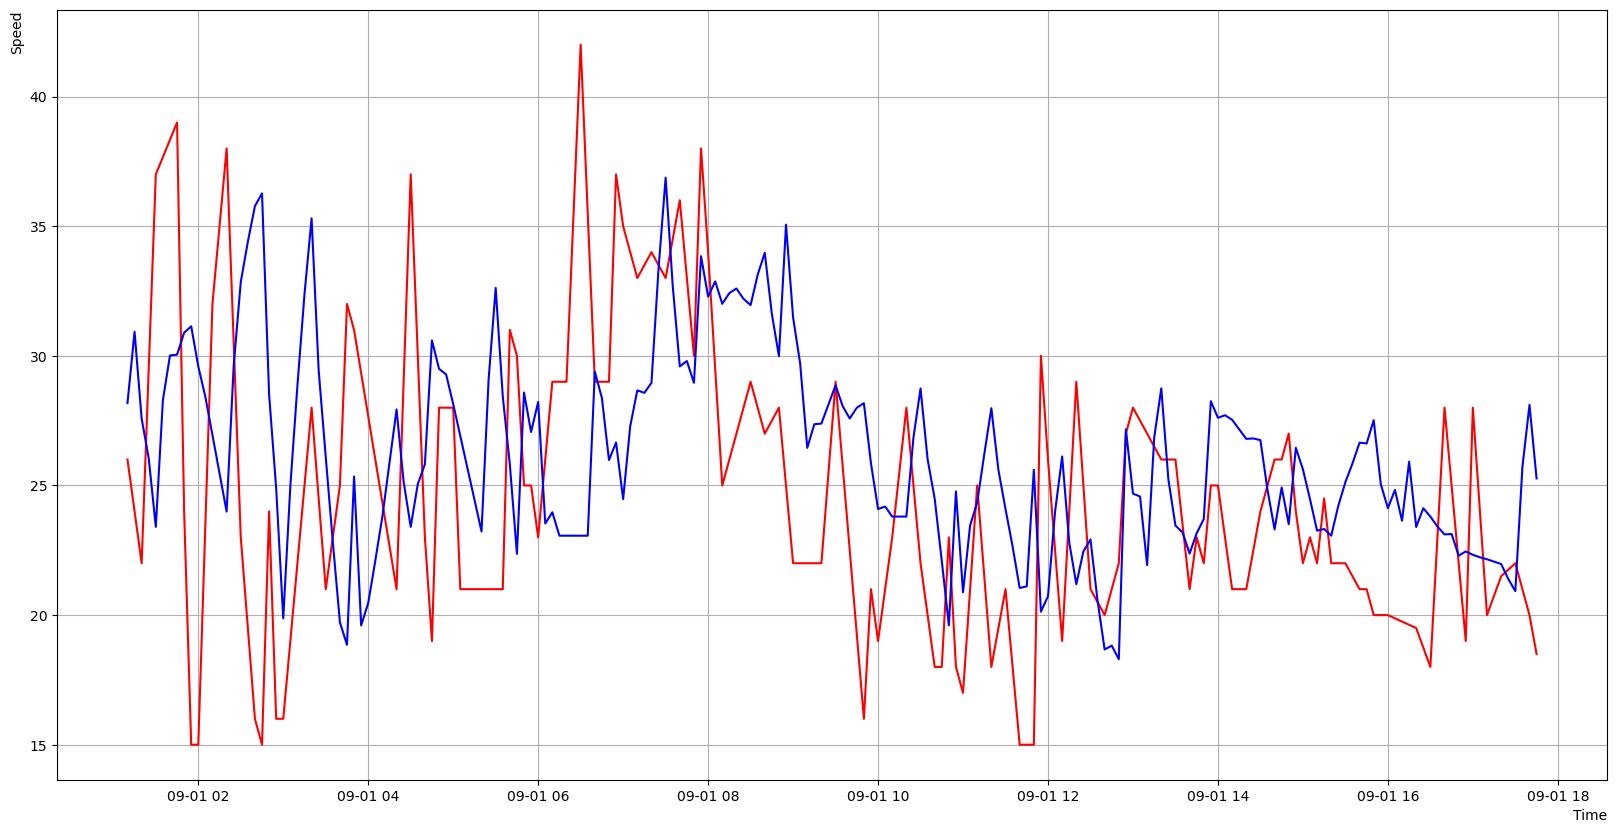

5.057254724502563


In [13]:
time_len = 200
d1_start = prev_len + next_step - 1
d1 = pd.read_csv('./data/processed_data/traffic/202310.csv').iloc[d1_start:d1_start+time_len, 0].reset_index(drop=True)
d2 = result.iloc[:time_len,0]
x = [datetime.datetime(2023, 9, 1) + i*datetime.timedelta(minutes=5) for i in range(d1_start, d1_start+time_len)]
show_plot(x, d1, d2)
print(np.abs(d1-d2).mean())